<a href="https://colab.research.google.com/github/NeginKhalifat/TensorFlow_PracticeNotes/blob/main/11_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network 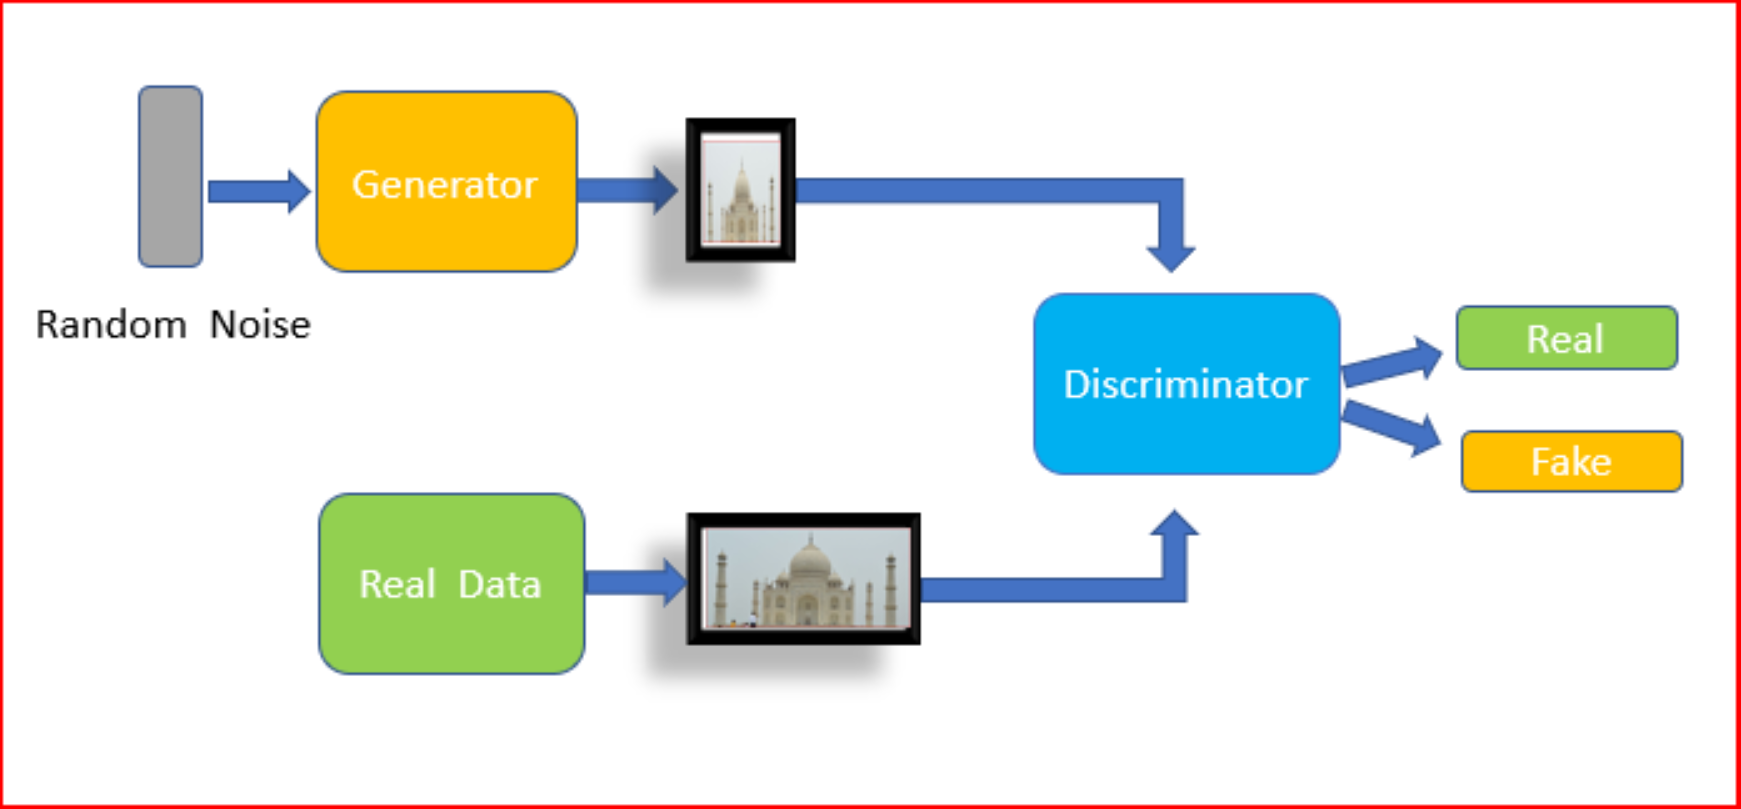

It has 2 parts:


1.   Generator: Unlike embedding(point to vector) it's convert noise vector to image  
2.   Discriminator: decide which image is real 



In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization,LeakyReLU, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import sys, os
import numpy as np

In [2]:
mnist = tf.keras.datasets.mnist
(X_train,y_train),(X_test, y_test) = mnist.load_data()
X_train,X_test  = X_train/ 255.0*2-1, X_test/ 255.0*2-1

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
N,H,W = X_train.shape
D = H*W
X_train =X_train.reshape(-1,D)
X_test =X_test.reshape(-1,D)

In [4]:
latent_dim = 100  # dimention of the noise that we want to pass into the generator
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256,activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  
  x = Dense(512,activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D,activation='tanh')(x) # because image are between -1,+1 we use tanh
  model = Model(i,x)
  return model

  

In [5]:
def build_discriminator(image_size):
  i = Input(shape=(image_size,))

  x = Dense(256,activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(512,activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1,activation='sigmoid')(x)
  model = Model(i,x)
  return model

In [6]:
discriminator = build_discriminator(D)
Adam = optimizer=tf.keras.optimizers.Adam
discriminator.compile(optimizer=Adam(.0002,.5),loss='binary_crossentropy',metrics=['accuracy'])
generator = build_generator(latent_dim)


Combine these 2 parts together

In [7]:
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)
combined_model =Model(z,fake_pred)
combined_model.compile(loss='binary_crossentropy',optimizer=Adam(.0002,.5))

# train the GAN

In [11]:
batch_size = 32
epochs = 3000
sample_period = 200   # generate image evry 200 steps

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

# create image from noise in generator:

In [20]:
def sample_image(epoch):
  rows, cols = 5,5
  noise = np.random.randn(rows*cols,latent_dim)         #25 image 
  imgs = generator.predict(noise)
  imgs = .5* imgs +.5
  fig, axis = plt.subplots(rows,cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axis[i][j].imshow(imgs[idx].reshape(H,W),cmap='gray')
      axis[i][j].axis('off')
      idx+=1
  fig.savefig('gan_images/%d.png'%epoch)
  plt.close()


In [21]:
for epoch in range(epochs):
  # train the discriminator
  idx = np.random.randint(0,X_train.shape[0],batch_size)
  real_images = X_train[idx]

  noise = np.random.randn(batch_size,latent_dim)         #25 image 
  fake_images = generator.predict(noise)
  d_losses_real, d_acc_real = discriminator.train_on_batch(real_images,ones)
  d_losses_fake, d_acc_fake = discriminator.train_on_batch(fake_images,zeros)
  d_loss = .5*(d_losses_real+d_losses_fake)
  d_acc = 0.5*(d_acc_real+ d_acc_fake)

  # train the generator
  noise = np.random.randn(batch_size,latent_dim)         #25 image 
  g_loss = combined_model.train_on_batch(noise,ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)
  if epoch %100==0:
    print(f"epoch: {epoch+1}/{epoches}, d_loss: {d_loss:.2f}, \ d_acc: {d_acc:.2f} ,  g_loss:{g_loss:.2f}")
  if epoch % sample_period ==0:
    sample_image(epoch)

epoch: 1/3000, d_loss: 0.47, \ d_acc: 0.73 ,  g_loss:1.55
epoch: 101/3000, d_loss: 0.53, \ d_acc: 0.75 ,  g_loss:1.34
epoch: 201/3000, d_loss: 0.56, \ d_acc: 0.72 ,  g_loss:1.11
epoch: 301/3000, d_loss: 0.72, \ d_acc: 0.56 ,  g_loss:1.27
epoch: 401/3000, d_loss: 0.55, \ d_acc: 0.72 ,  g_loss:1.40
epoch: 501/3000, d_loss: 0.54, \ d_acc: 0.72 ,  g_loss:1.34
epoch: 601/3000, d_loss: 0.55, \ d_acc: 0.67 ,  g_loss:1.23
epoch: 701/3000, d_loss: 0.58, \ d_acc: 0.77 ,  g_loss:1.54
epoch: 801/3000, d_loss: 0.53, \ d_acc: 0.73 ,  g_loss:1.24
epoch: 901/3000, d_loss: 0.68, \ d_acc: 0.62 ,  g_loss:1.42
epoch: 1001/3000, d_loss: 0.59, \ d_acc: 0.69 ,  g_loss:1.23
epoch: 1101/3000, d_loss: 0.60, \ d_acc: 0.70 ,  g_loss:1.37
epoch: 1201/3000, d_loss: 0.54, \ d_acc: 0.70 ,  g_loss:1.32
epoch: 1301/3000, d_loss: 0.58, \ d_acc: 0.64 ,  g_loss:1.42
epoch: 1401/3000, d_loss: 0.63, \ d_acc: 0.64 ,  g_loss:1.38
epoch: 1501/3000, d_loss: 0.60, \ d_acc: 0.66 ,  g_loss:1.13
epoch: 1601/3000, d_loss: 0.58, \ d_

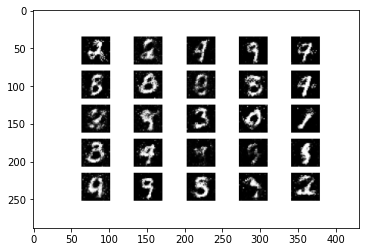

In [23]:
from skimage.io import imread
a= imread('gan_images/1000.png')
plt.imshow(a)